<a href="https://colab.research.google.com/github/HGuo90s/PriceOptimization/blob/main/notebook/Pricing_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Price Optimization <br>
This project focuses price optimization to increase the profit margins. Through the investigation on a series of topics, including demand forecasting, price of elasticity of demand calculation, customer segmentation, and personalized pricing, the project provides recommendations to improve pricing, monetization, and profits. <br>
<br>
<a name='contenttable'></a>
Table of Contents <br>
1. [Data Processing](#dataprocess)
2. [Statistical Analysis](#stats)
3. [Demand Forecasting: Basic Model](#demandforecast)
4. Pricing and Price Elasticity
5. Customer Segmentation
6. Personalized Pricing

In [ ]:
import os, csv
import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import userdata, files, drive
! pip install -q kaggle
! pip install -q opendatasets
import opendatasets as od
import kagglehub

<a name='dataprocess'></a>
#### 1 Data Processing <br>
The dataset is a public Kaggle dataset. The dataset contains the customer transaction data at an online retail store in UK. <br>
The data contains the following attributes of transactions
<br>

[Kaggle](https://www.kaggle.com/datasets/thedevastator/online-retail-transaction-data/data) <br>
Data Source: [By UCI](https://data.world/uci) <br>
<br>
[Back to Table of Contents](#contenttable)

In [ ]:
# Create directory for Kaggle credentials
!mkdir -p ~/.kaggle
# Upload your kaggle.json file (you'll get a file upload widget)
files.upload()
# Move the uploaded file to the kaggle directory
!cp kaggle.json ~/.kaggle/
# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Download the online retail transaction data
!kaggle datasets download -d thedevastator/online-retail-transaction-data
# Unzip the downloaded file
!unzip online-retail-transaction-data.zip
# read the dataset
df = pd.read_csv('online_retail.csv')

Dataset URL: https://www.kaggle.com/datasets/thedevastator/online-retail-transaction-data
License(s): other
 58% 5.00M/8.68M [00:00<00:00, 48.7MB/s]
100% 8.68M/8.68M [00:00<00:00, 64.6MB/s]
Archive:  online-retail-transaction-data.zip
  inflating: online_retail.csv       


In [ ]:
# print the shape of the dataframe
print(f"Row Count: {df.shape[0]}, Column Count: {df.shape[1]}")
print(f"Columns: {df.columns.tolist()}")

Row Count: 541909, Column Count: 9
Columns: ['index', 'InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


In [ ]:
# quick glance at the dataset
df.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# check the data type of each column
df.dtypes

,0
index,int64
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,float64
Country,object


In [ ]:
# process the dataset
df1 = df.copy()
# convert the data to proper types
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'])
df1['InvoiceNo'] = df1['InvoiceNo'].astype('str')
df1['StockCode'] = df1['StockCode'].astype('str')
df1['Description'] = df1['Description'].astype('str')
df1['Country'] = df1['Country'].astype('str')
df1['UnitPrice'] = df1['UnitPrice'].astype('float')
df1['CustomerID'] = df1['CustomerID'].astype('float')
# calculate the sales per product
df1['Sales'] = df1['Quantity'] * df1['UnitPrice']

In [ ]:
# review the duplicates and null values
# get the null values by columns
col_nan_cnt = df1.isnull().sum()
col_nan_pct = round(100*df1.isnull().sum()/df1.shape[0],2)
col_nan = pd.concat([col_nan_cnt, col_nan_pct], axis=1)
col_nan.columns = ['cnt', 'pct']
print(f"""Duplicates: {df1.duplicated().sum()}
Null Values:
{col_nan} """)

Duplicates: 0
Null Values:
                cnt    pct
index             0   0.00
InvoiceNo         0   0.00
StockCode         0   0.00
Description       0   0.00
Quantity          0   0.00
InvoiceDate       0   0.00
UnitPrice         0   0.00
CustomerID   135080  24.93
Country           0   0.00
Sales             0   0.00 


In [ ]:
# based on the observation, customer ids come as float number
# rounded to one decimal place. check if the ids can be converted
# to integers
df1['CustomerID_Int'] = df1['CustomerID'].astype('Int64')
print(f"""Customer ID Count: {df1.CustomerID.nunique()},
Customeer ID can be converted to int: \
{df1[df1.CustomerID==df1.CustomerID_Int].CustomerID.nunique()}""")

Customer ID Count: 4372,
Customeer ID can be converted to int: 4372


In [ ]:
# as confirmed in the previous step, drop the decimal place for
# customer IDs and convert it to string for easier inference later
df1['CustomerID'] = df1['CustomerID'].astype('Int64').astype('str')
df1.drop(columns=['CustomerID_Int'], inplace=True)

In [ ]:
# examine the negative quantity
# as specified, the invoice starts with "C" are cancellations
print(f"""Cancellation: { df1[df1.InvoiceNo.str.startswith('C')].shape[0] }
Negative Quantity { df1[df1.Quantity<0].shape[0] }
Cancellation and Negative Quantity { df1[(df1.InvoiceNo.str.startswith('C'))
& (df1.Quantity<0)].shape[0] }
Cancellation and Non-negative Quantity { df1[
    (df1.InvoiceNo.str.startswith('C')) & (df1.Quantity>=0)].shape[0] }
Negative Quantity and non-Cancellation { df1[
    ~(df1.InvoiceNo.str.startswith('C')) & (df1.Quantity<0)].shape[0] }
""")
df1[df1.Quantity<0].head()

Cancellation: 9288
Negative Quantity 10624
Cancellation and Negative Quantity 9288
Cancellation and Non-negative Quantity 0
Negative Quantity and non-Cancellation 1336



,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
141,141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,-27.50
154,154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,-4.65
235,235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,-19.80
236,236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96
237,237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,-6.96


In [ ]:
# examine the transactions with negative quantity and not a cancellation
cond1 = ~(df1.InvoiceNo.str.startswith('C')) & (df1.Quantity<0)
df1[cond1].head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
2406,2406,536589,21777,nan,-10,2010-12-01 16:50:00,0.0,<NA>,United Kingdom,-0.0
4347,4347,536764,84952C,nan,-38,2010-12-02 14:42:00,0.0,<NA>,United Kingdom,-0.0
7188,7188,536996,22712,nan,-20,2010-12-03 15:30:00,0.0,<NA>,United Kingdom,-0.0
7189,7189,536997,22028,nan,-20,2010-12-03 15:30:00,0.0,<NA>,United Kingdom,-0.0
7190,7190,536998,85067,nan,-6,2010-12-03 15:30:00,0.0,<NA>,United Kingdom,-0.0


In [ ]:
# as shown in description, unit price are all zeros for these transaction
df1[cond1].UnitPrice.describe()

,UnitPrice
count,1336.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [ ]:
# these transactions will be dropped from the analysis
cnt00, cnt01 = df1.shape[0], df1[cond1].shape[0]
df1 = df1[~cond1]
print(f"""Drop transactions that have negative quantity and are \
not cancellations.
Rows before: {cnt00}, Rows dropped: {cnt01}, \
Rows After: {df1.shape[0]}""")
# store all cancellations in a separate dataframe to be used for analysis
cnt02, cnt03 = df1.shape[0], df1[df1.InvoiceNo.str.startswith('C')].shape[0]
df_cancel = df1[df1.InvoiceNo.str.startswith('C')]
df1 = df1[~(df1.InvoiceNo.str.startswith('C'))]
print(f"""Store cancellations in a separate dataframe. Drop cancellations \
from the main dataframe.
Rows before: {cnt02}, Rows dropped: {cnt03}, \
Rows after: {df1.shape[0]}""")

Drop transactions that have negative quantity and are not cancellations.
Rows before: 541909, Rows dropped: 1336, Rows After: 540573
Store cancellations in a separate dataframe. Drop cancellations from the main dataframe.
Rows before: 540573, Rows dropped: 9288, Rows after: 531285


In [ ]:
# examine the zero unit price
# note that for the same product, unit price may be different
up_smry = df1[df1.UnitPrice>0].groupby('StockCode').agg(
    unitpricecnt=('UnitPrice', 'nunique'))
print(up_smry.unitpricecnt.value_counts())
# glance at the zero unit price
df1[df1.UnitPrice==0].head()

unitpricecnt
4      872
3      831
1      556
2      529
5      523
6      289
7      156
8       72
9       36
10      21
11      19
12      10
13       2
14       2
15       1
686      1
131      1
53       1
Name: count, dtype: int64


,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
622,622,536414,22139,nan,56,2010-12-01 11:52:00,0.0,<NA>,United Kingdom,0.0
1970,1970,536545,21134,nan,1,2010-12-01 14:32:00,0.0,<NA>,United Kingdom,0.0
1971,1971,536546,22145,nan,1,2010-12-01 14:33:00,0.0,<NA>,United Kingdom,0.0
1972,1972,536547,37509,nan,1,2010-12-01 14:33:00,0.0,<NA>,United Kingdom,0.0
1987,1987,536549,85226A,nan,1,2010-12-01 14:34:00,0.0,<NA>,United Kingdom,0.0


In [ ]:
# drop the transactions with zero unit price
cnt10, cnt11 = df1.shape[0], df1[df1.UnitPrice==0].shape[0]
df1 = df1[df1.UnitPrice!=0]
print(f"""Rows before: {cnt10}, Rows dropped: {cnt11}, \
Rows after: {df1.shape[0]}""")

Rows before: 531285, Rows dropped: 1179, Rows after: 530106


In [ ]:
# examine the transactions with negative unit price
df1[df1.UnitPrice<0].head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
299983,299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,<NA>,United Kingdom,-11062.06
299984,299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,<NA>,United Kingdom,-11062.06


In [ ]:
# for invoice number starts with A
df1[df1.InvoiceNo.str.startswith('A')]

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
299982,299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,<NA>,United Kingdom,11062.06
299983,299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,<NA>,United Kingdom,-11062.06
299984,299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,<NA>,United Kingdom,-11062.06


In [ ]:
# although the bad debit adjustment is critical for the company
# it is not useful in the analysis
# drop the records of bad debit
cnt20, cnt21 = df1.shape[0], df1[df1.InvoiceNo.str.startswith('A')].shape[0]
df1 = df1[~df1.InvoiceNo.str.startswith('A')]
print(f"""Rows before: {cnt20}, Rows dropped: {cnt21}, \
Rows after: {df1.shape[0]}""")

Rows before: 530106, Rows dropped: 3, Rows after: 530103


In [ ]:
# glance at the dataset after processing.
df1.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


<a name='stats'></a>
#### 2. Statistical Analysis
<br>
This section will provide a brief summary of the transactions. The summary will be performed by invoice number, product (stock code), country, and dates.  
<br>

[Back to Table of Contents](#contenttable)

In [ ]:
# summarize basic statistics by invoice
invoice_smry = df1.groupby('InvoiceNo', as_index=False).agg(
    invoice_cnt=('InvoiceNo', 'count'),
    customer_cnt=('CustomerID', 'nunique'),
    total_sales=('Sales', 'sum'),
    product_cnt=('StockCode', 'nunique'),
    invoice_date=('InvoiceDate', 'max'),
    invoice_date_min=('InvoiceDate', 'min'),
    country=('Country', 'max'),
    invoice_date_cnt = ('InvoiceDate', 'nunique'),
    country_cnt = ('Country', 'nunique'))

In [ ]:
# check the unique dates and countries by invoices
# see if dates and countries are the same by the same invoice
print(f"""
Customer Count: {invoice_smry.customer_cnt.unique()}
Invoice Date Count: {invoice_smry.invoice_date_cnt.unique()}
Country Count: {invoice_smry.country_cnt.unique()}""")


Customer Count: [1]
Invoice Date Count: [1 2]
Country Count: [1]


In [ ]:
# summarize the date difference if the invoice dates are difference
# for the same transactions
invoice_smry['date_diff'] = (invoice_smry.invoice_date
                             - invoice_smry.invoice_date_min)
invoice_smry.date_diff.value_counts().reset_index()
# as shown in the summary, the invoice date differences are within
# one minute. Not too much of difference.
# the analsis below will use the invoice_date (maximum date)

,date_diff,count
0,0 days 00:00:00,19917
1,0 days 00:01:00,42


<ipython-input-16-ac2a9a7d3e2f>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ind_ax.set_xticklabels(ind_ax.get_xticklabels(), rotation=45)
<ipython-input-16-ac2a9a7d3e2f>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ind_ax.set_xticklabels(ind_ax.get_xticklabels(), rotation=45)
<ipython-input-16-ac2a9a7d3e2f>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ind_ax.set_xticklabels(ind_ax.get_xticklabels(), rotation=45)
<ipython-input-16-ac2a9a7d3e2f>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ind_ax.set_xticklabels(ind_ax.get_xticklabels(), rotation=45)


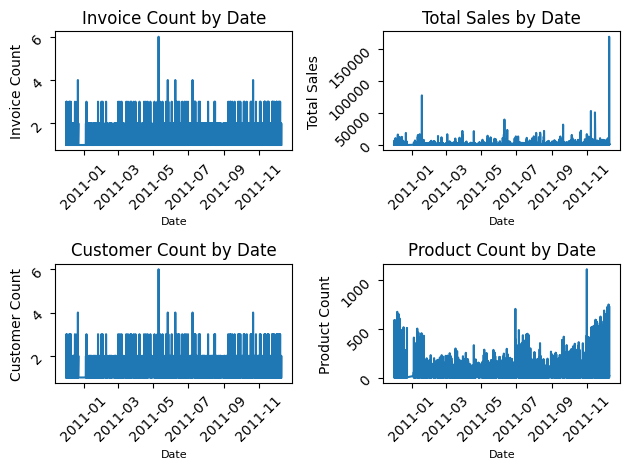

In [ ]:
# summarize the invoice counts by dates
invoice_dt_smry = invoice_smry.groupby('invoice_date', as_index=False).agg(
    invoice_cnt=('InvoiceNo', 'count'),
    customer_cnt=('customer_cnt', 'sum'),
    total_sales=('total_sales', 'sum'),
    product_cnt=('product_cnt', 'sum') )
# visualize invoice (transactions), customers, sales, and products by dates
fig, ax = plt.subplots(2,2)
ax[0,0].plot(invoice_dt_smry.invoice_date, invoice_dt_smry.invoice_cnt)
ax[0,0].set_ylabel('Invoice Count', fontsize=10)
ax[0,0].set_title('Invoice Count by Date')
ax[1,0].plot(invoice_dt_smry.invoice_date, invoice_dt_smry.customer_cnt)
ax[1,0].set_ylabel('Customer Count')
ax[1,0].set_title('Customer Count by Date')
ax[0,1].plot(invoice_dt_smry.invoice_date, invoice_dt_smry.total_sales)
ax[0,1].set_ylabel('Total Sales')
ax[0,1].set_title('Total Sales by Date')
ax[1,1].plot(invoice_dt_smry.invoice_date, invoice_dt_smry.product_cnt)
ax[1,1].set_ylabel('Product Count')
ax[1,1].set_title('Product Count by Date')
for ind_ax in ax.flat:
  ind_ax.tick_params(rotation=45)
  ind_ax.set_xticklabels(ind_ax.get_xticklabels(), rotation=45)
  ind_ax.set_xlabel('Date', fontsize=8)
plt.tight_layout()
plt.show()

<a name='demandforecast'></a>
#### 3. Demand Forecasting
3.1 [ARIMA models](#arima)
<br>

[Back to Table of Contents](#contenttable)

In [ ]:
product = df1.copy()
product['t_dt'] = product.InvoiceDate.dt.date
product['t_dt_hr'] = product.InvoiceDate.dt.hour
product['t_dt_min'] = product.InvoiceDate.dt.minute
product.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,t_dt,t_dt_hr,t_dt_min
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,8,26
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,8,26
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,8,26
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,8,26
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,8,26


In [ ]:
# Define category keywords
categories = {
    "Home Decor": ["CANDLE", "HOLDER", "LANTERN", "HANGING", "WALL",
                   "DECORATION", "VASE"],
    "Kitchen & Dining": ["MUG", "CAKE", "PLATE", "CUP", "GLASS", "JAR",
                         "CUTLERY"],
    "Jewelry & Accessories": ["NECKLACE", "EARRINGS", "BRACELET", "RING"],
    "Seasonal & Festive": ["CHRISTMAS", "EASTER", "HALLOWEEN", "DECORATION",
                           "WRAP", "GIFT"],
    "Storage & Organization": ["BOX", "HOLDER", "STORAGE", "RACK"],
    "Fashion & Bags": ["BAG", "PURSE", "HANDBAG", "TOTE"],
    "Garden & Outdoor": ["GARDEN", "PLANT", "POT", "OUTDOOR"],
    "Stationery & Cards": ["CARD", "PAPER", "NOTEBOOK", "DIARY", "WRAP"]
}
# Function to categorize a product based on its description
def categorize_product(description):
    description = description.upper()
    for category, keywords in categories.items():
        if any(keyword in description for keyword in keywords):
            return category
    return "Other"
# Apply categorization
product["Category"] = product["Description"].apply(categorize_product)

In [ ]:
# summarize the product category counts
p_cat_smry = product.groupby('Category', as_index=False).agg(
    product_cnt=('StockCode', 'nunique'),
    quantity_sum=('Quantity', 'sum'),
    Sales_sum=('Sales', 'sum') )
p_cat_smry

,Category,product_cnt,quantity_sum,Sales_sum
0,Fashion & Bags,174,560561,1021282.450
1,Garden & Outdoor,155,250896,629501.260
2,Home Decor,554,730395,1076655.970
3,Jewelry & Accessories,294,106402,121720.540
4,Kitchen & Dining,422,758553,1388341.670
5,Other,1779,2189874,4900157.524
6,Seasonal & Festive,246,430788,545494.360
7,Stationery & Cards,182,297959,382494.160
8,Storage & Organization,138,262947,589974.550


In [ ]:
product.head()

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,t_dt,t_dt_hr,t_dt_min,Category
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,8,26,Home Decor
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,8,26,Home Decor
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,8,26,Kitchen & Dining
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,8,26,Other
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,8,26,Other


In [ ]:
# summarize the demand quantity for individual products
product_daily_demand = product.groupby(
    by=['StockCode', 'Description', 'Category', 't_dt'], as_index=False).agg(
    demand_quantity=('Quantity', 'sum'))
# the first date and last date available in the products table
print(f"""First Date: {product_daily_demand.t_dt.min()}
Last Date: {product_daily_demand.t_dt.max()}""")
# obtain all combinations of product stock code and dates
date_unique = pd.date_range(product_daily_demand.t_dt.min(),
                            product_daily_demand.t_dt.max())
product_unique = product_daily_demand.StockCode.unique()
product_date_full = list(itertools.product(product_unique, date_unique))
product_date_full = pd.DataFrame(product_date_full,
                                 columns=['StockCode', 't_dt'])
product_date_full['t_dt'] = pd.to_datetime(product_date_full['t_dt'])
product_daily_demand['t_dt'] = pd.to_datetime(product_daily_demand['t_dt'])
# combine the full combination with the actual demand quantity
product_daily_demand = pd.merge(product_date_full, product_daily_demand,
                                how='left', on=['StockCode', 't_dt'])
# full the null values with zeros
product_daily_demand.fillna({'demand_quantity': 0}, inplace=True)

First Date: 2010-12-01
Last Date: 2011-12-09


In [ ]:
# summarize the demand quantity by category
product_cat_daily_demand = product.groupby(
    by=['Category', 't_dt'], as_index=False).agg(
    demand_quantity=('Quantity', 'sum'))
# obtain all combinations of product stock code and dates
date_unique = pd.date_range(product_daily_demand.t_dt.min(),
                            product_daily_demand.t_dt.max())
product_cat_unique = product_daily_demand.Category.unique()
product_cat_date_full = list(itertools.product(product_cat_unique,
                                               date_unique))
product_cat_date_full = pd.DataFrame(product_cat_date_full,
                                 columns=['Category', 't_dt'])
product_cat_daily_demand['t_dt'] = pd.to_datetime(
    product_cat_daily_demand['t_dt'])
# combine the full combination with the actual demand quantity
product_cat_daily_demand = pd.merge(product_cat_date_full,
                                    product_cat_daily_demand,
                                how='left', on=['Category', 't_dt'])
# full the null values with zeros
product_cat_daily_demand.fillna({'demand_quantity': 0}, inplace=True)

<a name='arima'></a>
3.1 ARIMA Models <br>
Build ARIMA demand forecasting models for different categories. Apply ADF test (Augmented Dicky-Fuller test) to check stationarity. Utilize ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) to determine ARIMA parameters. Apply ARIMA/SARIMA model in forecasting. <br>
3.1.0 [Functions](arima_function) <br>
3.1.1 [Stationarity](#arima_stationarity) <br>
3.1.2 Category 1: [Home Decor](#arima_cat1) <br>
3.1.3 Category 2: [Kitchen & Dining](#arima_cat2) <br>
3.1.4 Category 3: [Storage & Organization](#arima_cat3) <br>
3.1.5 Category 4: [Seasonal & Festive](#arima_cat4) <br>
3.1.6 Category 5: Stationaery & Cards <br>
3.1.7 Category 6: Gardens & Outdoor <br>
3.1.8 Category 7: Fashion & Bags <br>
3.1.9 Category 8: Jewelry & Accessories <br>
3.1.10 Category 9: Others <br>
<br>

Back to [Table of Contents](#contenttable) <br>
Back to [Demand Forecasting](#demandforecast)

<a name='arima_function'></a>
3.1.0 Functions <br>
This section lists the functions used throughout this section (3.1 ARIMA models).
<br>

Back to [Table of Contents](#contenttable) <br>
Back to [Demand Forecasting](#demandforecast) <br>
Back to [ARIMA Models](#arima)

In [ ]:
# define the function to run acf pacf
def run_acf_pacf(df, col, col_spec, val_col, lags=20, fs=(6,3)):
  if col is not None and col_spec is not None and val_col is not None:
    sub_df = df[df[col_spec]==col][[val_col]]
  elif col==None and col_spec==None and val_col==None:
    if isinstance(df, pd.Series):
      sub_df = df
    else:
      raise ValueError('Invalid input')
  else:
    raise ValueError('Invalid Column Specification input')
  fig, axes = plt.subplots(1, 2, figsize=fs)  # subplots
  # Plot ACF
  plot_acf(sub_df, lags=lags, ax=axes[0])
  axes[0].set_title("Autocorrelation Function (ACF)", fontsize=8)
  # Plot PACF
  plot_pacf(sub_df, lags=lags, ax=axes[1])
  axes[1].set_title("Partial Autocorrelation Function (PACF)", fontsize=8)
  plt.tight_layout()  # Adjust spacing
  plt.show()

In [ ]:
# define the function to obtain the forecasting results
# with bscia ARIMA or SARIMA
def run_arima(df, col, col_spec, dt, val_col, mdl, param, fs=(6,3),
              mth='nm', maxitercnt=10000, printdates=False,
              dispmsg=False):
  try:
    p, q, d = param
  except:
    try: p, q, d, P, D, Q, s = param
    except:
      raise ValueError('Invalid parameter')
  sub_df = df[df[col_spec]==col][[dt, val_col]]
  sub_df.set_index(dt, inplace=True)
  sub_df = sub_df.asfreq('D')
  # get the first 80% of the dates
  train_size = int(len(sub_df)*0.8)
  train, test = sub_df.iloc[:train_size], sub_df.iloc[train_size:]
  if printdates:
    print(f"""Train dates: {train.index.min()} - {train.index.max()}
          Test dates: {test.index.min()} - {test.index.max()} """)
  # fit the ARIMA model
  if mdl=='ARIMA':
    model = ARIMA(train, order=(p, d, q))
    results = model.fit(maxiter=maxitercnt, disp=dispmsg)
  elif mdl=='SARIMA':
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
    results = model.fit(method=mth, maxiter=maxitercnt, disp=dispmsg)
  else:
    raise ValueError('Invalid model')
  # get the AIC/BIC from the mode
  aic, bic = results.aic, results.bic
  # forecast future values
  forecast = results.get_forecast(steps=len(test))
  forecast_mean = forecast.predicted_mean
  forecast_ci = forecast.conf_int()
  # obtain the mse/mae/rmse
  observed = test['demand_quantity']
  mae = mean_absolute_error(observed, forecast_mean)
  mse = mean_squared_error(observed, forecast_mean)
  return mae, mse, np.sqrt(mse), aic, bic, \
  forecast_mean, forecast_ci, train, test

In [ ]:
# define the function to compare the parameters of ARIMA/SARIMA models
def compare_param(df, col, col_spec, dt, val_col, mdl, param_list,
                  fs=(6,3),
                  maxitercnt=10000, dispmsg=False):
  result_df = []
  for param in param_list:
    mae, mse, rmse, aic, bic, _, _, _, _ = run_arima(
      df, col, col_spec, dt, val_col, mdl, param, fs=fs,
      maxitercnt=maxitercnt, dispmsg=dispmsg)
    result_df.append({'params': param, 'mae': mae, 'mse': mse,
                      'rmse': rmse,'aic': aic, 'bic': bic})
  result_df = pd.DataFrame(result_df)
  result_df['mae_rank'] = result_df.mae.rank()
  result_df['mse_rank'] = result_df.mse.rank()
  result_df['aic_rank'] = result_df.aic.rank()
  result_df['bic_rank'] = result_df.bic.rank()
  return result_df

In [ ]:
# define the function to run the visualization
def plot_forecast(df, col, col_spec, dt, val_col, mdl, param, fs=(6,3),
                  maxitercnt=10000 ):
  try:
    p, q, d = param
  except:
    try: p, q, d, P, D, Q, s = param
    except:
      raise ValueError('Invalid parameter')
  try:
    mdl in ['ARIMA', 'SARIMA']
  except:
    raise ValueError('Invalid model')
  sub_df = df[df[col_spec]==col][[dt, val_col]]
  sub_df.set_index(dt, inplace=True)
  sub_df = sub_df.asfreq('D')
  mae, mse, rmse, aic, bic, forecast_mean, forecast_ci, train, test \
  = run_arima(df, col, col_spec, dt, val_col, mdl, param, fs)
  print(f"""MAE: {mae}.
        MSE: {mse}.
        RMSE: {np.sqrt(mse)}. """)
  # plot the forecast
  plt.figure(figsize=fs)
  plt.plot(train.index, train['demand_quantity'], label='Training Data')
  plt.plot(test.index, test['demand_quantity'], label='Testing Data')
  plt.plot(forecast_mean, label='Forecast', color='red')
  plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0],
                   forecast_ci.iloc[:, 1], color='pink')
  plt.title("Sales Forecast")
  plt.xlabel("Date")
  plt.ylabel("Sales")
  plt.legend()
  plt.show()

<a name='arima_stationarity'></a>
3.1.1 Stationarity <br>
Stationarity is an important concept in time series.
<br>

Back to [Table of Contents](#contenttable) <br>
Back to [Demand Forecasting](#demandforecast) <br>
Back to [ARIMA Models](#arima)

In [ ]:
# stationary check
# run the adf test on daily demand for each individual product
for cat in product.Category.unique():
  print(f'Category: {cat}.')
  adf_test = adfuller(
      product_cat_daily_demand[product_cat_daily_demand.Category==cat]\
      .demand_quantity)
  print(f"""ADF Statistic: {adf_test[0]}. \
  p-value: {adf_test[1]}""")

Category: Home Decor.
ADF Statistic: -1.3601045535611387.   p-value: 0.6012461183207928
Category: Kitchen & Dining.
ADF Statistic: -18.394789120127037.   p-value: 2.1975638960401472e-30
Category: Other.
ADF Statistic: -1.8786289980545698.   p-value: 0.3421805167688231
Category: Storage & Organization.
ADF Statistic: -3.010287066772608.   p-value: 0.03394482172059935
Category: Seasonal & Festive.
ADF Statistic: -1.0593048957308777.   p-value: 0.7310249401246969
Category: Stationery & Cards.
ADF Statistic: 2.6666203074332855.   p-value: 0.9990845259930793
Category: Garden & Outdoor.
ADF Statistic: -4.264452011610701.   p-value: 0.0005115695892349214
Category: Fashion & Bags.
ADF Statistic: -2.7278171072897144.   p-value: 0.0693471439909188
Category: Jewelry & Accessories.
ADF Statistic: -4.00354438835557.   p-value: 0.0013920650900452643


In [ ]:
# stationary check, adf
stationary_df = []
for cat in product.Category.unique():
  adf_test = adfuller(
      product_cat_daily_demand[product_cat_daily_demand.Category==cat]\
      .demand_quantity)
  stationary_df.append({'Category': cat, 'adf_test_stats': adf_test[0],
   'adf_test_pval': round(adf_test[1],6)})
stationary_df = pd.DataFrame(stationary_df)
stationary_df
# based on adf test, some categories are stationary
# kitchen & dining, storage & organization, garden & outdoor,
# jewelery & accessories

,Category,adf_test_stats,adf_test_pval
0,Home Decor,-1.360105,0.601246
1,Kitchen & Dining,-18.394789,0.000000
2,Other,-1.878629,0.342181
3,Storage & Organization,-3.010287,0.033945
4,Seasonal & Festive,-1.059305,0.731025
5,Stationery & Cards,2.666620,0.999085
6,Garden & Outdoor,-4.264452,0.000512
7,Fashion & Bags,-2.727817,0.069347
8,Jewelry & Accessories,-4.003544,0.001392


<a name='arima_cat1'></a>
3.1.2 Category 1: Home Decor
<br>

Back to [Table of Contents](#contenttable) <br>
Back to [Demand Forecasting](#demandforecast) <br>
Back to [ARIMA Models](#arima)


ADF (Home Decor)  $p_{value} \approx 0.601246 \leqslant 0.05$ <br>
Home Decor Demand is not stationary, a trend or seasonality exists. <br>
Run ACF/PACF to determine which level of differencing to apply.

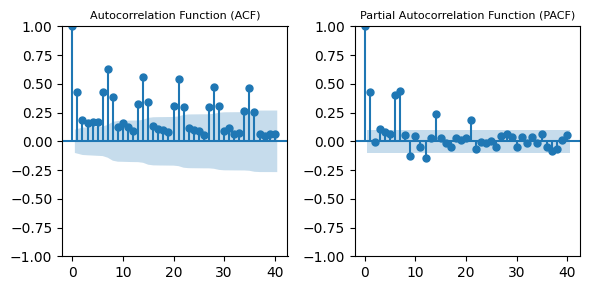

In [ ]:
# examine home decor ACF/PACF
run_acf_pacf(product_cat_daily_demand, 'Home Decor', 'Category',
             'demand_quantity', 40)

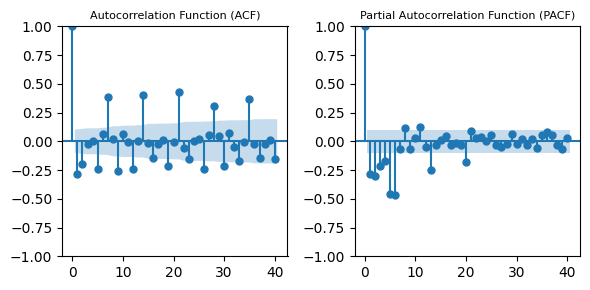

In [ ]:
# run first level differencing
home_decor_diff = product_cat_daily_demand[
    product_cat_daily_demand.Category=='Home Decor'].demand_quantity.diff()
home_decor_diff.dropna(inplace=True)
run_acf_pacf(home_decor_diff, None, None, None, 40)

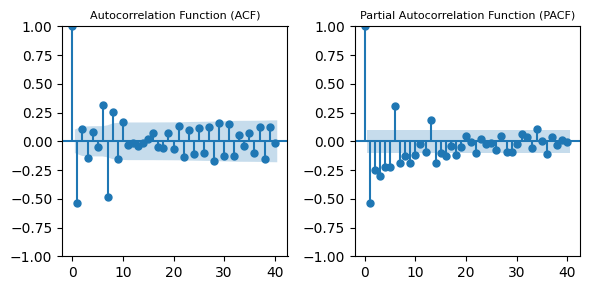

In [ ]:
# run seasonal differencing on top of first level differencing
home_decor_diff_1_7 = home_decor_diff.diff(7)
home_decor_diff_1_7.dropna(inplace=True)
run_acf_pacf(home_decor_diff_1_7, None, None, None, 40)

In [ ]:
# run sarima with different parameters
p = [1,2,3]
d, q, P, D, Q, s = 1, 1, 1, 1, 1, 7
param = [p, d, q, P, D, Q, s]
mae, mse, rmse, _, _, _, _= run_arima(product_cat_daily_demand, 'Home Decor',
           'Category', 't_dt', 'demand_quantity', 'SARIMA',
            [1, 0, 0, 1, 0, 0, 7], (7,4))
print(mae, mse, rmse)

Train dates: 2010-12-01 00:00:00 - 2011-09-25 00:00:00
  Test dates: 2011-09-26 00:00:00 - 2011-12-09 00:00:00 
2974.0688237140757 13424756.130933126 3663.980913014303


In [ ]:
home_decor_result = []
p_comb = [1,2,3]
for p in p_comb:
  pdqPDQs = [p, 1, 1, 1, 1, 1, 7]
  print(pdqPDQs)
  mae, mse, rmse, aic, bic, _, _, _, _ = run_arima(
      product_cat_daily_demand, 'Home Decor', 'Category', 't_dt',
      'demand_quantity', 'SARIMA', pdqPDQs)
  home_decor_result.append({'params': pdqPDQs, 'mae': mae, 'mse': mse,
                            'rmse': rmse,'aic': aic, 'bic': bic})
home_decor_result = pd.DataFrame(home_decor_result)
home_decor_result

[1, 1, 1, 1, 1, 1, 7]
Train dates: 2010-12-01 00:00:00 - 2011-09-25 00:00:00
  Test dates: 2011-09-26 00:00:00 - 2011-12-09 00:00:00 
Optimization terminated successfully.
         Current function value: 7.981092
         Iterations: 328
         Function evaluations: 539
[2, 1, 1, 1, 1, 1, 7]
Train dates: 2010-12-01 00:00:00 - 2011-09-25 00:00:00
  Test dates: 2011-09-26 00:00:00 - 2011-12-09 00:00:00 


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 7.980008
         Iterations: 662
         Function evaluations: 1049
[3, 1, 1, 1, 1, 1, 7]
Train dates: 2010-12-01 00:00:00 - 2011-09-25 00:00:00
  Test dates: 2011-09-26 00:00:00 - 2011-12-09 00:00:00 
Optimization terminated successfully.
         Current function value: 7.977294
         Iterations: 723
         Function evaluations: 1077


,params,mae,mse,rmse,aic,bic
0,"[1, 1, 1, 1, 1, 1, 7]",1499.883822,3.607413e+06,1899.319104,4782.693309,4801.059925
1,"[2, 1, 1, 1, 1, 1, 7]",1542.095557,3.771317e+06,1941.987953,4784.044665,4806.084604
2,"[3, 1, 1, 1, 1, 1, 7]",1395.121143,3.095093e+06,1759.287560,4784.422034,4810.135297


Train dates: 2010-12-01 00:00:00 - 2011-09-25 00:00:00
  Test dates: 2011-09-26 00:00:00 - 2011-12-09 00:00:00 
Optimization terminated successfully.
         Current function value: 7.981092
         Iterations: 328
         Function evaluations: 539
MAE: 1499.883821637815.
        MSE: 3607413.0588167724.
        RMSE: 1899.319103999318. 


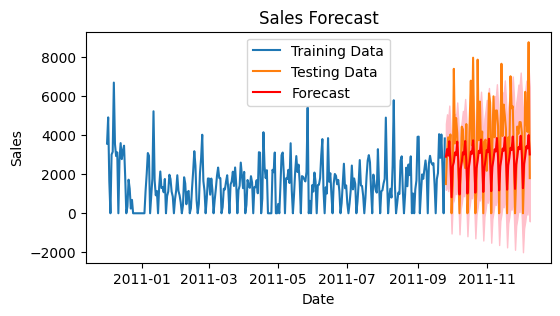

In [ ]:
plot_forecast(product_cat_daily_demand, 'Home Decor', 'Category',
           't_dt', 'demand_quantity', 'SARIMA',
            [1, 1, 1, 1, 1, 1, 7])

<a name='arima_cat2'></a>
Section 3.1.3 Category 2: Kitchen & Dining <br>

Back to [Table of Contents](#contenttable) <br>
Back to [Demand Forecasting](#demandforecast) <br>
Back to [ARIMA Models](#arima)

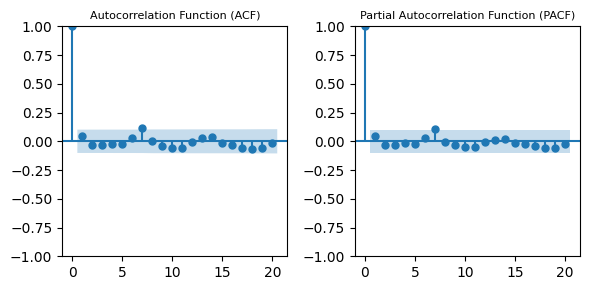

In [ ]:
# examine kitchen & dining
run_acf_pacf(product_cat_daily_demand, 'Kitchen & Dining', 'Category',
             'demand_quantity')
# based on the ACF/PACF plot, the appropriate model is ARIMA(0,0,0)
# random flunctuation/random walk

MAE: 1100.4782608695652.
        MSE: 2243427.9200732284.
        RMSE: 1497.8077046380915. 


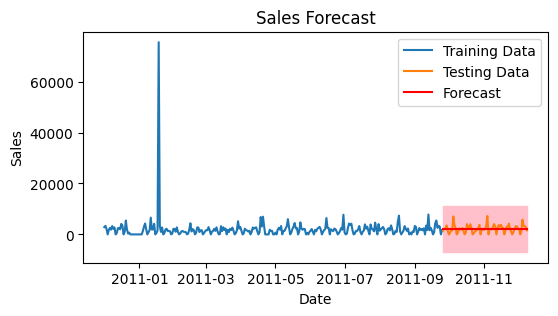

In [ ]:
plot_forecast(product_cat_daily_demand, 'Kitchen & Dining',
           'Category', 't_dt', 'demand_quantity', 'ARIMA',
            [0, 0, 0])

In [ ]:
kitchen_result = []
p_comb = [0,1,2,3]
q_comb = [0,1,2,3]
for p in p_comb:
  for q in q_comb:
    pdq = [p,0,q]
    mae, mse, rmse, aic, bic, _, _, _, _ = run_arima(
      product_cat_daily_demand,'Kitchen & Dining', 'Category', 't_dt',
      'demand_quantity', 'ARIMA', pdq)
    kitchen_result.append({'params': pdq, 'mae': mae, 'mse': mse,
                            'rmse': rmse,'aic': aic, 'bic': bic})
kitchen_result = pd.DataFrame(kitchen_result)
kitchen_result['mae_rank'] = kitchen_result.mae.rank()
kitchen_result['mse_rank'] = kitchen_result.mse.rank()
kitchen_result['aic_rank'] = kitchen_result.aic.rank()
kitchen_result['bic_rank'] = kitchen_result.bic.rank()
kitchen_result

,params,mae,mse,rmse,aic,bic,mae_rank,mse_rank,aic_rank,bic_rank
0,"[0, 0, 0]",1.100478e+03,2.243428e+06,1.497808e+03,5884.900622,5892.301509,2.0,2.0,1.0,1.0
1,"[0, 0, 1]",1.205533e+03,2.543824e+06,1.594937e+03,6057.810491,6061.507584,5.0,6.0,8.0,8.0
2,"[0, 0, 2]",6.077809e+04,4.907216e+09,7.005153e+04,6357.251849,6360.945581,12.0,12.0,14.0,14.0
3,"[0, 0, 3]",4.635091e+06,3.800341e+13,6.164690e+06,6689.318100,6693.008460,16.0,16.0,16.0,16.0
4,"[1, 0, 0]",1.100281e+03,2.243248e+06,1.497748e+03,5886.235969,5897.337300,1.0,1.0,2.0,2.0
5,"[1, 0, 1]",1.461609e+03,3.410254e+06,1.846687e+03,5988.143065,5995.537251,8.0,8.0,7.0,7.0
6,"[1, 0, 2]",9.845411e+03,1.242381e+08,1.114622e+04,6199.397081,6206.784546,9.0,9.0,11.0,11.0
7,"[1, 0, 3]",1.502686e+06,4.004517e+12,2.001129e+06,6459.271160,6466.651879,15.0,15.0,15.0,15.0
8,"[2, 0, 0]",1.100988e+03,2.244033e+06,1.498010e+03,5887.942499,5902.744273,3.0,4.0,3.0,3.0
9,"[2, 0, 1]",1.333920e+03,2.936570e+06,1.713642e+03,5958.045743,5969.137023,7.0,7.0,6.0,6.0


MAE: 1100.2810751700708.
        MSE: 2243248.3327066815.
        RMSE: 1497.747753363924. 


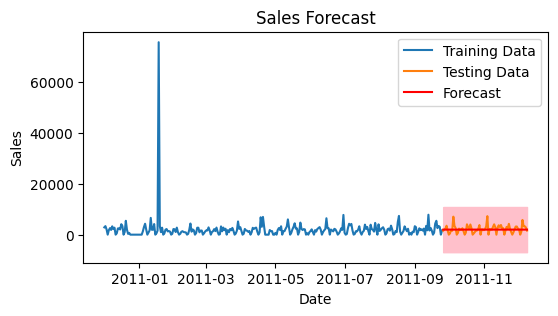

In [ ]:
# run basic sarima(1,0,0)(1,0,0)7 on storage and organization
plot_forecast(product_cat_daily_demand, 'Kitchen & Dining',
           'Category', 't_dt', 'demand_quantity', 'ARIMA',
            [1, 0, 0])

<a name='arima_cat3'></a>
Section 3.1.4 Category 3: Storage & Organization <br>

Back to [Table of Contents](#contenttable) <br>
Back to [Demand Forecasting](#demandforecast) <br>
Back to [ARIMA Models](#arima)

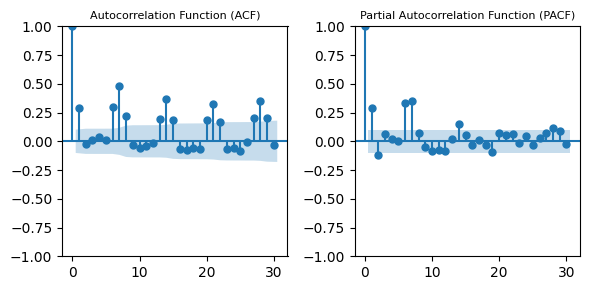

In [ ]:
# plot the acf pacf
run_acf_pacf(product_cat_daily_demand, 'Storage & Organization', 'Category',
             'demand_quantity', 30)

In [ ]:
storage_result = []
pdqPDQs = [
    [1, 0, 0, 1, 0, 0, 7], [1, 0, 1, 1, 0, 1, 7], [1, 0, 1, 1, 0, 0, 7],
    [1, 1, 0, 1, 0, 0, 7], [1, 1, 0, 1, 1, 0, 7], [1, 1, 1, 1, 1, 1, 7],
    [1, 0, 0, 1, 0, 0, 5], [1, 0, 1, 1, 0, 1, 5]]
for comb in pdqPDQs:
  pdqPDQs = [p, 0, 0, 1, 0, 0, 7]
  mae, mse, rmse, aic, bic, _, _, _, _ = run_arima(
      product_cat_daily_demand, 'Storage & Organization',
      'Category', 't_dt', 'demand_quantity', 'SARIMA', comb)
  storage_result.append({'params': comb, 'mae': mae, 'mse': mse,
                            'rmse': rmse,'aic': aic, 'bic': bic})
storage_result = pd.DataFrame(storage_result)
storage_result['mae_rank'] = storage_result.mae.rank()
storage_result['mse_rank'] = storage_result.mse.rank()
storage_result['aic_rank'] = storage_result.aic.rank()
storage_result['bic_rank'] = storage_result.bic.rank()
storage_result

Optimization terminated successfully.
         Current function value: 7.718742
         Iterations: 93
         Function evaluations: 173
Optimization terminated successfully.
         Current function value: 7.730065
         Iterations: 219
         Function evaluations: 367
Optimization terminated successfully.
         Current function value: 7.795051
         Iterations: 79
         Function evaluations: 146
Optimization terminated successfully.
         Current function value: 7.648442
         Iterations: 257
         Function evaluations: 427
Optimization terminated successfully.
         Current function value: 7.500997
         Iterations: 208
         Function evaluations: 351
Optimization terminated successfully.
         Current function value: 7.372238
         Iterations: 681
         Function evaluations: 1155
Optimization terminated successfully.
         Current function value: 7.865871
         Iterations: 101
         Function evaluations: 181
Optimization terminat

,params,mae,mse,rmse,aic,bic,mae_rank,mse_rank,aic_rank,bic_rank
0,"[1, 0, 0, 1, 0, 0, 7]",904.039259,1.458693e+06,1207.763827,4621.807516,4632.908847,7.0,7.0,4.0,4.0
1,"[1, 0, 1, 1, 0, 1, 7]",446.725375,5.002322e+05,707.270918,4630.579146,4645.367520,1.0,2.0,5.0,5.0
2,"[1, 0, 1, 1, 0, 0, 7]",676.461919,8.812451e+05,938.746581,4667.440542,4678.531822,6.0,6.0,6.0,6.0
3,"[1, 1, 0, 1, 0, 0, 7]",619.527356,7.483872e+05,865.093763,4581.768151,4596.569926,4.0,4.0,3.0,3.0
4,"[1, 1, 0, 1, 1, 0, 7]",447.506872,5.014392e+05,708.123721,4493.596482,4508.303498,2.0,3.0,2.0,2.0
5,"[1, 1, 1, 1, 1, 1, 7]",448.144079,4.941715e+05,702.973345,4418.598363,4436.964980,3.0,1.0,1.0,1.0
6,"[1, 0, 0, 1, 0, 0, 5]",1088.612967,1.906698e+06,1380.832305,4709.790904,4720.892234,8.0,8.0,7.0,7.0
7,"[1, 0, 1, 1, 0, 1, 5]",663.342067,8.385334e+05,915.714698,4711.888313,4726.676687,5.0,5.0,8.0,8.0


Optimization terminated successfully.
         Current function value: 7.372238
         Iterations: 681
         Function evaluations: 1155
MAE: 448.1440793331503.
        MSE: 494171.52346564573.
        RMSE: 702.9733447760632. 


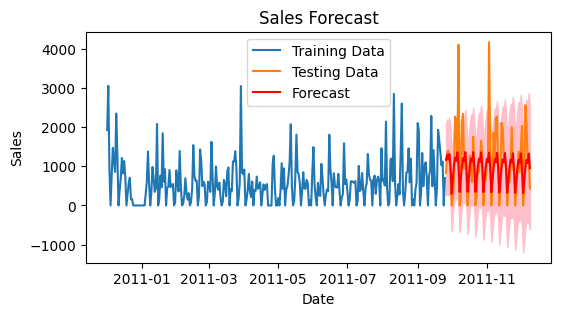

In [ ]:
# run the forecast plot
plot_forecast(product_cat_daily_demand, 'Storage & Organization',
           'Category', 't_dt', 'demand_quantity', 'SARIMA',
            [1, 1, 1, 1, 1, 1, 7])

<a name='arima_cat4'></a>
Section 3.1.5 Category 4: Seasonal and Festive <br>
Based on the ADF test, this category is not stationary. Perform Differencing.
<br>

Back to [Table of Contents](#contenttable) <br>
Back to [Demand Forecasting](#demandforecast) <br>
Back to [ARIMA Models](#arima)

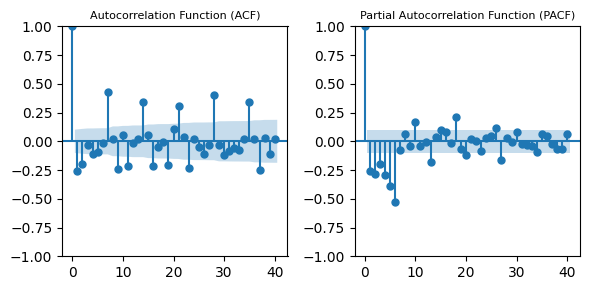

In [ ]:
# first order differencing on seasonal and festive
seasonal_diff = product_cat_daily_demand[
    product_cat_daily_demand.Category=='Seasonal & Festive'].\
    demand_quantity.diff()
seasonal_diff.dropna(inplace=True)
# plot acf/pacf
run_acf_pacf(seasonal_diff, None, None, None, 40)

In [ ]:
pdqPDQs = [
    [1, 1, 1, 1, 0, 1, 7], [2, 1, 1, 1, 0, 1, 7]]
compare_param(product_cat_daily_demand, 'Seasonal & Festive', 'Category',
             't_dt', 'demand_quantity', 'SARIMA', pdqPDQs)

,params,mae,mse,rmse,aic,bic,mae_rank,mse_rank,aic_rank,bic_rank
0,"[1, 1, 1, 1, 0, 1, 7]",1851.706194,4.879963e+06,2209.063721,4596.386379,4614.871847,2.0,2.0,1.0,1.0
1,"[2, 1, 1, 1, 0, 1, 7]",1849.959718,4.872421e+06,2207.356138,4598.383665,4620.566226,1.0,1.0,2.0,2.0


MAE: 1851.7061943721612.
        MSE: 4879962.52248378.
        RMSE: 2209.0637207839386. 


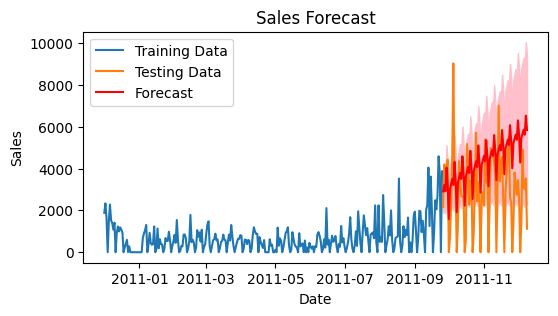

In [ ]:
# run forecast with a simpler model
plot_forecast(product_cat_daily_demand, 'Seasonal & Festive', 'Category',
           't_dt', 'demand_quantity', 'SARIMA',
            [1, 1, 1, 1, 0, 1, 7])

<a name='arima_cat5'></a>
Section 3.1.6 Category 6: Garden & Outdoor <br>
Based on the ADF test, this category is not stationary. Perform Differencing.
<br>

Back to [Table of Contents](#contenttable) <br>
Back to [Demand Forecasting](#demandforecast) <br>
Back to [ARIMA Models](#arima)

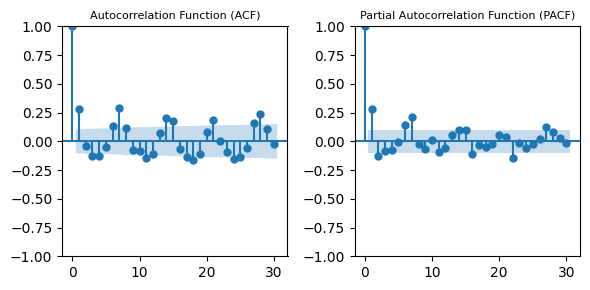

In [ ]:
# examine garden & tour
run_acf_pacf(product_cat_daily_demand, 'Garden & Outdoor', 'Category',
             'demand_quantity', 30)
# similary seasonality found, SARIMA(1,0,0)(1,0,0)7

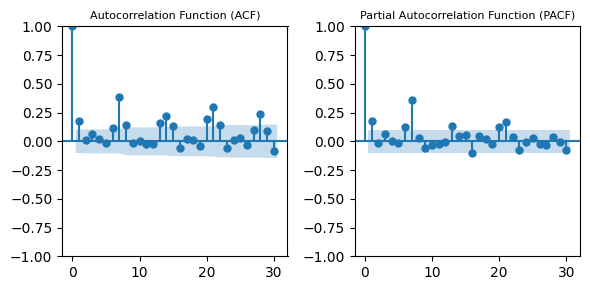

In [ ]:
# examine jewelry and accessories
run_acf_pacf(product_cat_daily_demand, 'Jewelry & Accessories', 'Category',
             'demand_quantity', 30)
# based on the ACF/PACF plot, the appropriate model is SARIMA(1,0,0)(1,0,0)7

In [ ]:
# run basic arima(0,0,0) on kitchen and dining
sub_df = product_cat_daily_demand[
    product_cat_daily_demand.Category=='Kitchen & Dining']
# get the first 80% of the dates
train_size = int(len(sub_df)*0.8)
train1, test1 = sub_df.iloc[:train_size], sub_df.iloc[train_size:]
print(f"""Train dates: {train.t_dt.min()} - {train.t_dt.max()}
Test dates: {test.t_dt.min()} - {test.t_dt.max()} """)
# Fit the ARIMA model on the training dataset
model1_train = ARIMA(train.demand_quantity, order=(0, 0, 0))
model1_train_fit = model1_train.fit()
# forecast based on the model
model1_forecast = model1_train_fit.forecast(steps=len(test))

Train dates: 2010-12-01 00:00:00 - 2011-09-25 00:00:00
Test dates: 2011-09-26 00:00:00 - 2011-12-09 00:00:00 


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

In [ ]:
def run_sarima(df, col, col_spec, dt, val_col, p, d, q, P, D, Q, s,
               fs=(6,3)):
  sub_df = df[df[col_spec]==col][[dt, val_col]]
  sub_df.set_index(dt, inplace=True)
  sub_df = sub_df.asfreq('D')
  # get the first 80% of the dates
  train_size = int(len(sub_df)*0.8)
  train, test = sub_df.iloc[:train_size], sub_df.iloc[train_size:]
  print(f"""Train dates: {train.index.min()} - {train.index.max()}
        Test dates: {test.index.min()} - {test.index.max()} """)
  # fit the SARIMA model
  model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
  results = model.fit()
  # forecast future values
  forecast = results.get_forecast(steps=len(test))
  forecast_mean = forecast.predicted_mean
  forecast_ci = forecast.conf_int()
  # obtain the mse/mae/rmse
  observed = test['demand_quantity']
  mae = mean_absolute_error(observed, forecast_mean)
  mse = mean_squared_error(observed, forecast_mean)
  print(f"""MAE: {mae}.
        MSE: {mse}.
        RMSE: {np.sqrt(mse)}. """)
  # plot the forecast
  plt.figure(figsize=fs)
  plt.plot(train.index, train['demand_quantity'], label='Training Data')
  plt.plot(test.index, test['demand_quantity'], label='Testing Data')
  plt.plot(forecast_mean, label='Forecast', color='red')
  plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0],
                   forecast_ci.iloc[:, 1], color='pink')
  plt.title("Sales Forecast")
  plt.xlabel("Date")
  plt.ylabel("Sales")
  plt.legend()
  plt.show()

Train dates: 2010-12-01 00:00:00 - 2011-09-25 00:00:00
        Test dates: 2011-09-26 00:00:00 - 2011-12-09 00:00:00 
MAE: 904.036290409071. 
        MSE: 1458686.4698484761. 
        RMSE: 1207.7609324069379. 


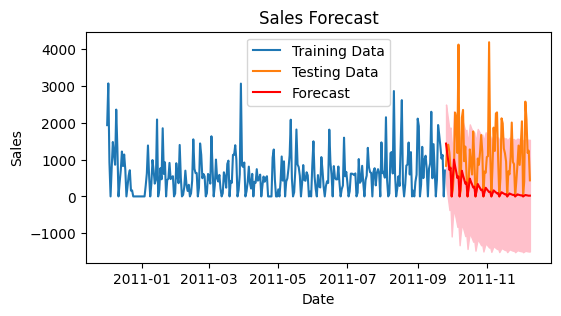

In [ ]:
# run basic sarima(1,0,0)(1,0,0)7 on storage and organization
run_sarima(product_cat_daily_demand, 'Storage & Organization',
           'Category', 't_dt', 'demand_quantity', 1, 0, 0, 1, 0, 0, 7)

Train dates: 2010-12-01 00:00:00 - 2011-09-25 00:00:00
        Test dates: 2011-09-26 00:00:00 - 2011-12-09 00:00:00 
MAE: 586.9062183564864. 
        MSE: 605103.8706203249. 
        RMSE: 777.8842270031736. 


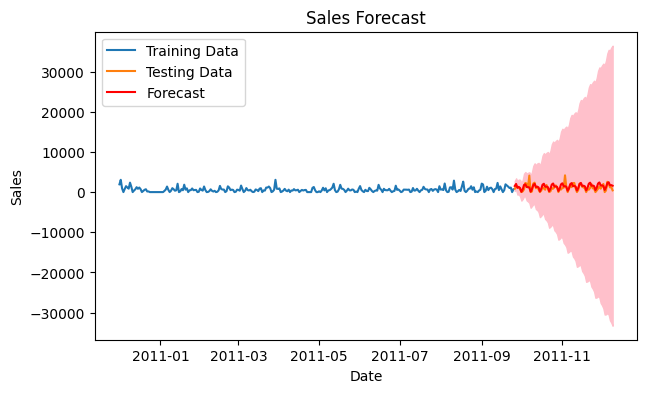

In [ ]:
# add moving average term, sarima(1,1,0)(1,1,0)7 on storage and organization
run_sarima(product_cat_daily_demand, 'Storage & Organization',
           'Category', 't_dt', 'demand_quantity', 1, 1, 0, 1, 1, 0, 7, (7,4))

Train dates: 2010-12-01 00:00:00 - 2011-09-25 00:00:00
        Test dates: 2011-09-26 00:00:00 - 2011-12-09 00:00:00 
MAE: 448.1450232128381. 
        MSE: 494165.0796536116. 
        RMSE: 702.9687615062362. 


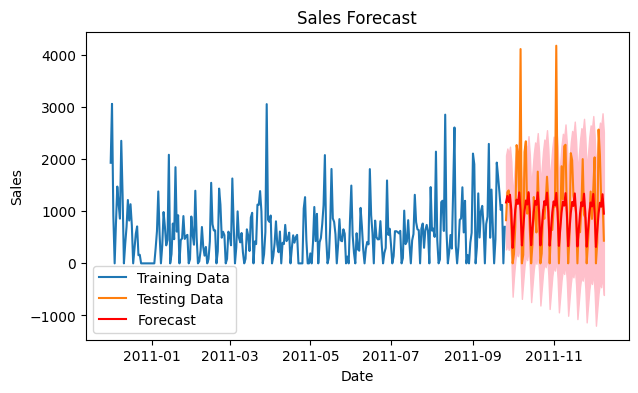

In [ ]:
# add moving average term, sarima(1,1,0)(1,1,0)7 on storage and organization
run_sarima(product_cat_daily_demand, 'Storage & Organization',
           'Category', 't_dt', 'demand_quantity', 1, 1, 1, 1, 1, 1, 7, (7,4))

Section 4 Pricing and Price Elasticity